First, we need to install libaries.

In [1]:
!pip install pygame neat-python ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 970.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


After that we need to import libraries.

In [2]:
import pygame
import neat
import os
import sys
import random
import colorsys
import time
from IPython.display import display, Javascript
from google.colab import output
from IPython.display import HTML

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
# Initialize gamepad and pygame
gamepad = ColabGamepad()
pygame.init()

Now we have to get the necessary files. These cannot be stored on google colab directly.

In [13]:
!git clone https://github.com/Max112358/Tensor-Bird.git
# Change working directory to Tensor-Bird
%cd /content/Tensor-Bird

# Add to Python path
sys.path.append('/content/Tensor-Bird')

# Now your image paths will be relative to the Tensor-Bird directory
from constants import BIRD_SIZE, GRAVITY, BIRD_JUMP_VELOCITY, MAX_FALL_SPEED

fatal: destination path 'Tensor-Bird' already exists and is not an empty directory.
/content/Tensor-Bird


In [3]:
import os

# Set up path to cloned repo
repo_path = "/content/Tensor-Bird"
art_path = os.path.join(repo_path, "art")
config_path = os.path.join(repo_path, "config-feedforward.txt")

After that we have our constants. These define how the game works and are largely responsible for its "feel."

In [5]:
# constants.py
import os
# Base/reference resolution
BASE_WIDTH = 1600
BASE_HEIGHT = 900
# Initialize pygame before getting screen info
import pygame
pygame.init()
# Get current screen info
screen_info = pygame.display.Info()
MARGIN = 120  # Margin from screen edges
# Calculate available space
available_width = screen_info.current_w - MARGIN
available_height = screen_info.current_h - MARGIN
# Use whichever is smaller: base size or available space
SCREEN_WIDTH = min(BASE_WIDTH, available_width)
SCREEN_HEIGHT = min(BASE_HEIGHT, available_height)

# Window title
GAME_TITLE = "Tensor Bird"

# Screen setup - center the window
os_x_pos = (screen_info.current_w - SCREEN_WIDTH) // 2
os_y_pos = (screen_info.current_h - SCREEN_HEIGHT) // 2
os.environ['SDL_VIDEO_WINDOW_POS'] = f"{os_x_pos},{os_y_pos}"
SCREEN = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))


# Colors
SKY_BLUE = (135, 206, 235)

# Game settings
FPS = 120

# Sizes relative to screen
BIRD_SIZE = int(SCREEN_HEIGHT * 0.055)  # ~60px at 1100 height
PIPE_WIDTH = int(SCREEN_WIDTH * 0.0875)  # ~140px at 1600 width
PIPE_GAP = int(SCREEN_HEIGHT * 0.273)    # ~300px at 1100 height
PIPE_SPACING = int(SCREEN_WIDTH * 0.25)   # ~400px at 1600 width

# Safe margins for pipes (as percentage of screen height)
PIPE_TOP_MARGIN = int(SCREEN_HEIGHT * 0.1)    # 10% from top
PIPE_BOTTOM_MARGIN = int(SCREEN_HEIGHT * 0.1)  # 10% from bottom

# Pipe height range
PIPE_MIN_HEIGHT = PIPE_TOP_MARGIN + PIPE_GAP
PIPE_MAX_HEIGHT = SCREEN_HEIGHT - PIPE_BOTTOM_MARGIN - PIPE_GAP

# Positions
FLOOR_Y = SCREEN_HEIGHT
BIRD_START_X = SCREEN_WIDTH * 0.2        # 20% from left edge
BIRD_START_Y = SCREEN_HEIGHT * 0.45      # Slightly above middle
FIRST_PIPE_X = SCREEN_WIDTH * 0.625      # 62.5% across screen

# Physics
PIPE_VELOCITY = SCREEN_WIDTH * 0.00156    # Scales with screen width
BIRD_JUMP_VELOCITY = SCREEN_HEIGHT * -0.00636  # Scales with screen height
GRAVITY = SCREEN_HEIGHT * 0.000227        # Scales with screen height
MAX_FALL_SPEED = SCREEN_HEIGHT * 0.00727  # Scales with screen height

# Game parameters
VISIBLE_PIPES = 5  # Number of pipes visible at once

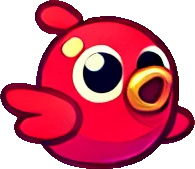Now im going to implement the bird class. This is used to represent the main character. Our protagonist!

In [6]:
import pygame
import colorsys
import random
from constants import BIRD_SIZE, GRAVITY, BIRD_JUMP_VELOCITY, MAX_FALL_SPEED

class Bird:
    def __init__(self, x, y):
        original_image = pygame.image.load('art/bird.png')
        self.original_image = pygame.transform.scale(original_image, (BIRD_SIZE, BIRD_SIZE))
        self.bird_img = self.original_image.copy()
        self.width = BIRD_SIZE
        self.height = BIRD_SIZE

        # Generate random color variation for each bird
        random_hue = random.random()
        for px in range(self.width):  # Changed x to px
            for py in range(self.height):  # Changed y to py
                r, g, b, a = self.bird_img.get_at((px, py))  # Use px, py
                if a == 0:  # Skip transparent pixels
                    continue
                h, s, v = colorsys.rgb_to_hsv(r/255, g/255, b/255)
                new_h = (h + random_hue) % 1.0
                new_r, new_g, new_b = colorsys.hsv_to_rgb(new_h, s, v)
                self.bird_img.set_at((px, py),  # Use px, py
                    (int(new_r*255), int(new_g*255), int(new_b*255), a))

        # Physics properties
        self.x = x
        self.y = y

        self.velocity = 0
        self.terminal_velocity = MAX_FALL_SPEED

        # Visual properties
        self.angle = 0
        self.max_upward_angle = 20
        self.max_downward_angle = -90
        self.rotation_speed = 4

    def move(self):
        # Update velocity with gravity and terminal velocity
        self.velocity += GRAVITY
        if self.velocity > self.terminal_velocity:
            self.velocity = self.terminal_velocity

        # Update position
        self.y += self.velocity

        # Update rotation based on velocity
        if self.velocity < 0:
            target_angle = self.max_upward_angle
        else:
            # Smooth rotation downward based on fall speed
            fall_ratio = min(self.velocity / self.terminal_velocity, 1.0)
            target_angle = self.max_downward_angle * fall_ratio

        # Smoothly interpolate to target angle
        if self.angle < target_angle:
            self.angle = min(target_angle, self.angle + self.rotation_speed)
        elif self.angle > target_angle:
            self.angle = max(target_angle, self.angle - self.rotation_speed)

    def jump(self):
        self.velocity = BIRD_JUMP_VELOCITY

    def draw(self, screen):
        rotated_bird = pygame.transform.rotate(self.bird_img, self.angle)
        new_rect = rotated_bird.get_rect(center=(self.x + self.width//2,
                                                self.y + self.height//2))
        screen.blit(rotated_bird, new_rect.topleft)

Now we need our pipe class. This represents obstacles. The antagonist!

In [7]:
# pipe.py
import pygame
import random
from constants import SCREEN_HEIGHT, PIPE_WIDTH, PIPE_GAP, PIPE_VELOCITY

class Pipe:
    def __init__(self, x):
        self.UP_PIPE_IMG = pygame.image.load('art/purple_pipe.png')
        self.DOWN_PIPE_IMG = pygame.image.load('art/purple_pipe.png')

        # Calculate scale based on aspect ratio
        up_pipe_aspect_ratio = self.UP_PIPE_IMG.get_height() / self.UP_PIPE_IMG.get_width()
        down_pipe_aspect_ratio = self.DOWN_PIPE_IMG.get_height() / self.DOWN_PIPE_IMG.get_width()

        self.UP_PIPE_IMG = pygame.transform.scale(self.UP_PIPE_IMG,
                                       (PIPE_WIDTH, int(PIPE_WIDTH * up_pipe_aspect_ratio)))
        self.DOWN_PIPE_IMG = pygame.transform.scale(self.DOWN_PIPE_IMG,
                                         (PIPE_WIDTH, int(PIPE_WIDTH * down_pipe_aspect_ratio)))

        self.x = x

        # First, determine where the gap should be
        # Leave room for at least 100px of pipe at top and bottom
        min_gap_y = 100
        max_gap_y = SCREEN_HEIGHT - PIPE_GAP - 100

        # This is the Y coordinate where the gap starts
        self.gap_y = random.randrange(min_gap_y, max_gap_y)

        # Now calculate positions for both pipes
        self.top_y = self.gap_y - self.DOWN_PIPE_IMG.get_height()
        self.bottom_y = self.gap_y + PIPE_GAP
        self.height = self.gap_y  # For collision detection
        self.passed = False

        # Create collision rectangles
        self.top_rect = pygame.Rect(self.x, 0, PIPE_WIDTH, self.gap_y)
        self.bottom_rect = pygame.Rect(self.x, self.bottom_y, PIPE_WIDTH,
                                     SCREEN_HEIGHT - self.bottom_y)

    def move(self):
        self.x -= PIPE_VELOCITY
        self.top_rect.x = self.x
        self.bottom_rect.x = self.x

    def draw(self, screen):
        screen.blit(self.DOWN_PIPE_IMG, (self.x, self.top_y))
        screen.blit(self.UP_PIPE_IMG, (self.x, self.bottom_y))

After that we need some utility functions for drawing and collisions.

In [8]:
# game_utils.py
import pygame
from constants import BIRD_SIZE, FLOOR_Y, SCREEN_WIDTH

def check_collision(bird, pipe):
    bird_rect = pygame.Rect(bird.x, bird.y, BIRD_SIZE, BIRD_SIZE)

    # Check pipe collisions first
    pipe_collision = (bird_rect.colliderect(pipe.top_rect) or
                     bird_rect.colliderect(pipe.bottom_rect))

    # Check ceiling and floor collisions
    # Use bird_rect.bottom to ensure bird dies when its bottom edge hits floor
    ceiling_collision = bird.y < 0
    floor_collision = bird_rect.bottom > FLOOR_Y

    if pipe_collision or ceiling_collision or floor_collision:
        # Calculate center position of bird for death marker
        center_x = bird.x + BIRD_SIZE // 2
        center_y = bird.y + BIRD_SIZE // 2
        return True, (center_x, center_y)
    return False, None

def draw_game(screen, background, pipes, birds, score, death_markers=None):
    background.draw(screen)

    for pipe in pipes:
        pipe.draw(screen)

    if death_markers:
        for marker in death_markers:
            marker.draw(screen)

    for bird in birds:
        bird.draw(screen)

    font = pygame.font.Font(None, 100)
    score_text = font.render(str(score), True, (255, 255, 255))
    screen.blit(score_text, (SCREEN_WIDTH/2 - score_text.get_width()/2, 100))

    pygame.display.update()

Now a class to run the parallax background. This isnt necessary for functionality, but it looks nice.

In [9]:
import pygame
from constants import PIPE_VELOCITY

class Background:
    def __init__(self, screen_width, screen_height):
        # Load and scale background image
        self.background_img = pygame.image.load('art/background.png')

        # Scale background to match screen height while maintaining aspect ratio
        bg_aspect_ratio = self.background_img.get_width() / self.background_img.get_height()
        self.background_img = pygame.transform.scale(
            self.background_img,
            (int(screen_height * bg_aspect_ratio), screen_height)
        )

        # Set up scrolling parameters
        self.width = self.background_img.get_width()
        self.x1 = 0
        self.x2 = self.width  # Second image starts where first image ends
        self.velocity = PIPE_VELOCITY * 0.4  # Background moves at 40% of pipe speed

    def move(self):
        # Move both images to the left
        self.x1 -= self.velocity
        self.x2 -= self.velocity

        # If an image has moved completely off screen to the left,
        # move it back to the right edge
        if self.x1 + self.width < 0:
            self.x1 = self.x2 + self.width
        if self.x2 + self.width < 0:
            self.x2 = self.x1 + self.width

    def draw(self, screen):
        # Draw both background images
        screen.blit(self.background_img, (self.x1, 0))
        screen.blit(self.background_img, (self.x2, 0))

 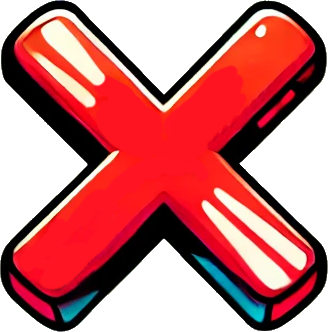
 Now the death marker class, which shows you when your birds have died.

In [ ]:
# death_marker.py
import pygame
from constants import PIPE_VELOCITY, PIPE_WIDTH

class DeathMarker:
    def __init__(self, x, y):
        """
        Initialize a death marker at the specified coordinates.
        The marker is centered on the death location.

        Args:
            x (int): X coordinate of death location
            y (int): Y coordinate of death location
        """
        original_image = pygame.image.load('art/red_x.png')
        self.size = 80  # Size of the marker
        self.image = pygame.transform.scale(original_image, (self.size, self.size))
        # Center the X on death location
        self.x = x - self.size // 2
        self.y = y - self.size // 2

    def move(self):
        """Move the death marker left at the same speed as pipes"""
        self.x -= PIPE_VELOCITY

    def is_offscreen(self):
        """Check if the death marker has moved completely off screen"""
        return self.x + self.size < -PIPE_WIDTH

    def draw(self, screen):
        """
        Draw the death marker on the screen.

        Args:
            screen: Pygame surface to draw on
        """
        screen.blit(self.image, (self.x, self.y))

And now that we have all of that, we have a playable version of flappy bird! However this was built for pygame and not jupyter notebook, so its not going to run in the browser. 😞

In [14]:
# human_game.py
import pygame
import sys
from bird import Bird
from pipe import Pipe
from background import Background
from game_utils import check_collision
from death_marker import DeathMarker
from constants import *
import time

def main():
    pygame.init()
    pygame.display.set_caption(GAME_TITLE)

    clock = pygame.time.Clock()

    def reset_game():
        bird = Bird(SCREEN_WIDTH * 0.2, SCREEN_HEIGHT * 0.4)
        background = Background(SCREEN_WIDTH, SCREEN_HEIGHT)
        first_pipe_x = SCREEN_WIDTH * 0.75
        pipes = [Pipe(first_pipe_x + i * PIPE_SPACING) for i in range(VISIBLE_PIPES)]
        return bird, background, pipes, [], 0  # Added empty death_markers list

    bird, background, pipes, death_markers, score = reset_game()
    game_over = False
    death_time = 0
    DEATH_LOCKOUT = 1.5

    score_font = pygame.font.Font(None, int(SCREEN_HEIGHT * 0.091))
    game_over_font = pygame.font.Font(None, int(SCREEN_HEIGHT * 0.067))
    debug_font = pygame.font.Font(None, 36)
    game_over_text = game_over_font.render('Game Over! Press SPACE to restart', True, (255, 255, 255))
    game_over_rect = game_over_text.get_rect(center=(SCREEN_WIDTH/2, SCREEN_HEIGHT/2))

    while True:
        clock.tick(FPS)
        current_time = time.time()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    if game_over:
                        if current_time - death_time >= DEATH_LOCKOUT:
                            bird, background, pipes, death_markers, score = reset_game()
                            game_over = False
                    else:
                        bird.jump()

        if not game_over:
            bird.move()
            background.move()

            # Move and clean up death markers
            for marker in death_markers[:]:
                marker.move()
                if marker.is_offscreen():
                    death_markers.remove(marker)

            for pipe in pipes:
                pipe.move()

                collision, death_pos = check_collision(bird, pipe)
                if collision:
                    #print(f"Game Over! Death position: {death_pos}")
                    #print(f"Bird position: ({bird.x}, {bird.y})")
                    #print(f"Pipe position: x={pipe.x}, top_rect={pipe.top_rect}, bottom_rect={pipe.bottom_rect}")
                    if death_pos:
                        death_markers.append(DeathMarker(*death_pos))
                    game_over = True
                    death_time = current_time
                    break

                elif not pipe.passed and bird.x > pipe.x + PIPE_WIDTH:
                    pipe.passed = True
                    score += 1

            while len(pipes) > 0 and pipes[0].x < -PIPE_WIDTH:
                pipes.pop(0)
                pipes.append(Pipe(pipes[-1].x + PIPE_SPACING))

        # Draw everything
        SCREEN.fill(SKY_BLUE)
        background.draw(SCREEN)

        for pipe in pipes:
            pipe.draw(SCREEN)

        bird.draw(SCREEN)

        # Draw death markers after bird so they appear on top
        for marker in death_markers:
            marker.draw(SCREEN)

        # Draw score
        score_text = score_font.render(str(score), True, (255, 255, 255))
        score_rect = score_text.get_rect(center=(SCREEN_WIDTH/2, SCREEN_HEIGHT * 0.091))
        SCREEN.blit(score_text, score_rect)

        '''
        # Draw debug info
        if not game_over:
            debug_text = debug_font.render(f"Bird: ({int(bird.x)}, {int(bird.y)}) Vel: {bird.velocity:.1f}", True, (255, 255, 255))
            SCREEN.blit(debug_text, (10, 10))
        '''

        if game_over:
            if current_time - death_time < DEATH_LOCKOUT:
                lockout_text = game_over_font.render('Game Over!', True, (255, 255, 255))
            else:
                lockout_text = game_over_text
            SCREEN.blit(lockout_text, game_over_rect)

        pygame.display.flip()

if __name__ == "__main__":
    main()

KeyboardInterrupt: 

After that we can run the main AI program. This will also not work on colab.

In [ ]:
import pygame
import neat
import os
import sys
from constants import *
from bird import Bird
from pipe import Pipe
from background import Background
from game_utils import check_collision, draw_game
from death_marker import DeathMarker

def eval_genomes(genomes, config):
    try:
        # Initialize lists to track active birds and networks
        birds = []
        nets = []
        ge = []
        death_markers = []
        best_genome = None
        best_fitness = -float('inf')

        # Create neural networks for each genome
        for _, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)
            nets.append(net)
            birds.append(Bird(BIRD_START_X, BIRD_START_Y))
            genome.fitness = 0
            ge.append(genome)

        # Initialize game objects
        background = Background(SCREEN_WIDTH, SCREEN_HEIGHT)
        pipes = [Pipe(FIRST_PIPE_X + i * PIPE_SPACING) for i in range(VISIBLE_PIPES)]
        score = 0
        clock = pygame.time.Clock()

        run = True
        while run and len(birds) > 0:
            clock.tick(FPS)

            # Handle quit event
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    current_best = max(ge, key=lambda x: x.fitness)
                    print('\nBest genome at exit:\n{!s}'.format(current_best))
                    print(f'Final fitness: {current_best.fitness}')
                    pygame.quit()
                    sys.exit()

            # Move background for parallax effect
            background.move()

            # Move and clean up death markers
            for marker in death_markers[:]:
                marker.move()
                if marker.is_offscreen():
                    death_markers.remove(marker)

            # Determine which pipes to focus on (current and next)
            pipe_ind = 0
            next_pipe_ind = 1
            if len(birds) > 0:
                if len(pipes) > 1 and birds[0].x > pipes[0].x + PIPE_WIDTH:
                    pipe_ind = 1
                    next_pipe_ind = 2

            # Update all birds
            for x, bird in enumerate(birds):
                bird.move()
                ge[x].fitness += 0.1

                # Get the next pipe if available
                next_pipe = pipes[next_pipe_ind] if next_pipe_ind < len(pipes) else pipes[pipe_ind]

                # Neural network inputs (now including bird velocity)
                output = nets[x].activate((
                    #the bird itself
                    bird.y,  # Bird's height
                    bird.velocity,  # Bird's current velocity

                    #the pipes
                    abs(bird.y - pipes[pipe_ind].height),  # vertical distance to current pipe's gap
                    abs(bird.y - pipes[pipe_ind].bottom_y),  # vertical distance to current pipe's bottom
                    pipes[pipe_ind].x - bird.x,  # horizontal distance to current pipe
                    abs(bird.y - next_pipe.height),  # vertical distance to next pipe's gap
                    abs(bird.y - next_pipe.bottom_y),  # vertical distance to next pipe's bottom
                    next_pipe.x - bird.x  # horizontal istance to next pipe
                ))

                # Make the bird jump if output is > 0.5
                if output[0] > 0.5:
                    bird.jump()

                # Track best fitness
                if ge[x].fitness > best_fitness:
                    best_fitness = ge[x].fitness
                    best_genome = ge[x]

            # Update and check all pipes
            for pipe in pipes:
                pipe.move()

                # Check each bird for collisions
                x = 0
                while x < len(birds):
                    collision, death_pos = check_collision(birds[x], pipe)
                    if collision:
                        if death_pos:
                            death_markers.append(DeathMarker(*death_pos))
                        ge[x].fitness -= 1
                        birds.pop(x)
                        nets.pop(x)
                        ge.pop(x)
                    elif not pipe.passed and birds[x].x > pipe.x + PIPE_WIDTH:
                        pipe.passed = True
                        score += 1
                        # Reward for passing pipes
                        ge[x].fitness += 5
                    x += 1

            # Remove and add new pipes as needed
            while len(pipes) > 0 and pipes[0].x < -PIPE_WIDTH:
                pipes.pop(0)
                pipes.append(Pipe(pipes[-1].x + PIPE_SPACING))

            # Draw the current game state
            draw_game(SCREEN, background, pipes, birds, score, death_markers)

        return best_genome

    except pygame.error:
        sys.exit()

def run_neat(config_path, checkpoint_file=None):
    try:
        config = neat.config.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_path
        )

        if checkpoint_file and os.path.exists(checkpoint_file):
            print(f"Loading from checkpoint: {checkpoint_file}")
            pop = neat.Checkpointer.restore_checkpoint(checkpoint_file)
            start_gen = pop.generation

            # Reconstruct population from species
            all_members = {}
            for species in pop.species.species.values():
                all_members.update(species.members)
            pop.population = all_members

        else:
            if checkpoint_file:
                print(f"Checkpoint file {checkpoint_file} not found. Starting fresh.")
            pop = neat.Population(config)
            start_gen = 0

        pop.add_reporter(neat.StdOutReporter(True))
        stats = neat.StatisticsReporter()
        pop.add_reporter(stats)
        checkpointer = neat.Checkpointer(5, filename_prefix='neat-checkpoint-')
        pop.add_reporter(checkpointer)

        remaining_gens = 50 - start_gen
        winner = pop.run(eval_genomes, remaining_gens)
        print('\nBest genome:\n{!s}'.format(winner))

    except KeyboardInterrupt:
        print("\nSaving checkpoint before exiting...")
        current_gen = pop.generation
        # Save checkpoint with correct number of arguments
        checkpointer.save_checkpoint(config, pop, pop.species, current_gen)
        print(f"Checkpoint saved as neat-checkpoint-{current_gen}")
    except SystemExit:
        print("\nTraining terminated")

if __name__ == "__main__":
    pygame.init()
    pygame.display.set_caption(GAME_TITLE)
    local_dir = os.path.dirname(__file__)
    config_path = os.path.join(local_dir, "config-feedforward.txt")

    # Parse command line arguments
    checkpoint_file = None
    if len(sys.argv) > 2 and sys.argv[1] == '-load':
        checkpoint_file = sys.argv[2]

    run_neat(config_path, checkpoint_file)

I know this was a little anticlimactic so [here is a link to watch a video of the program running.](https://youtu.be/WNy5CEa5GZA)

The program works by random generation of neural nets. The bird that does the best has its brain copied 20 times, with slight alterations to it made at random. As such the most successful bird becomes the template for all other birds, one of which will presumably do better than its parents. This continues until the birds have mastered the game.

If you want some instructions on how to actually run the game, you can download the repo from github and install it yourself.

In [ ]:
https://github.com/Max112358/Tensor-Bird

After that type

In [ ]:
pip install .

to install dependencies.

Then you can type python main.py to run the program.